In [3]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

In [4]:
Nt=1000
P=np.zeros(Nt)
T=np.zeros(Nt)
k=3
r=1
dt=0.01

P[0]=0.2 #Initial conditions
T[0]=0
for i in range(1,Nt):
    P[i]=P[i-1]+ P[i-1]*r*(1-P[i-1]/k)*dt
    T[i]=T[i-1]+dt

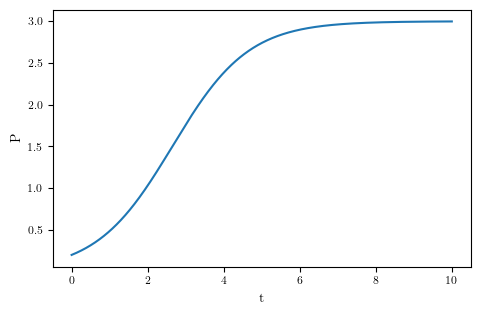

In [6]:
plt.plot(T,P)
plt.xlabel('t')
plt.ylabel('P')
plt.savefig('Simple_Eq_log.pdf')
plt.show()

In [7]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net_u(t, w, b):
    u = DNN(t, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W, b, r, k):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net_u(t, W, b)
    u_t = tape1.gradient(u, t) 
    f = u_t - r*u*(1-u/k)

    return f


#@tf.function()
@tf.function()
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, r, k):
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(t_u, W, b) 
        f_nn = net_f(t_f, W, b, r, k)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) +\
        tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W, b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss




# N_u = 100 # Number of Initial and Boundary data points
N_f = 100 # Number of residual point
N_d = 5 #Number of data
Nmax=  50000 #20000

layers = [1, 50, 50, 1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


In [8]:
u_star = P.reshape([-1, 1])
X_star = T.reshape([-1, 1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = T[0]
uu1 = P[0]

# Additional data
idx = np.random.choice(P.shape[0], N_d, replace=False)
xxd = T[idx]
uud = P[idx]

X_u_train = np.concatenate(([xx1],xxd)).reshape([-1,1])
u_train = np.concatenate(([uu1],uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)


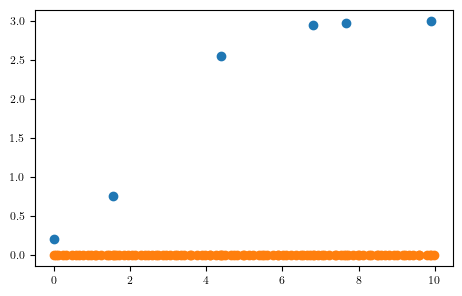

In [9]:
plt.scatter(X_u_train, u_train)
plt.scatter(X_f_train, np.zeros(len(X_f_train)))
plt.show()

In [10]:
lr = 1e-4
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_ = train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, r, k)
    loss.append(loss_)
    if n % 10 == 0:
        print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0 and loss is: 4.226626396179199
Iteration is: 10 and loss is: 3.5120625495910645
Iteration is: 20 and loss is: 2.9020864963531494
Iteration is: 30 and loss is: 2.379908323287964
Iteration is: 40 and loss is: 1.9296469688415527
Iteration is: 50 and loss is: 1.5393404960632324
Iteration is: 60 and loss is: 1.2017701864242554
Iteration is: 70 and loss is: 0.9136664271354675
Iteration is: 80 and loss is: 0.6741449236869812
Iteration is: 90 and loss is: 0.4828735589981079
Iteration is: 100 and loss is: 0.3383195102214813
Iteration is: 110 and loss is: 0.2365080565214157
Iteration is: 120 and loss is: 0.17072153091430664
Iteration is: 130 and loss is: 0.13232150673866272
Iteration is: 140 and loss is: 0.11235830187797546
Iteration is: 150 and loss is: 0.10320532321929932
Iteration is: 160 and loss is: 0.09947982430458069
Iteration is: 170 and loss is: 0.09803750365972519
Iteration is: 180 and loss is: 0.09737113118171692
Iteration is: 190 and loss is: 0.09690187126398087
Itera

In [11]:
def predict(X_star_tf, w, b):
    t_star = X_star_tf
    u_pred = net_u(t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
Error = 100* np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_pred)


Error u: 2.896042e-04


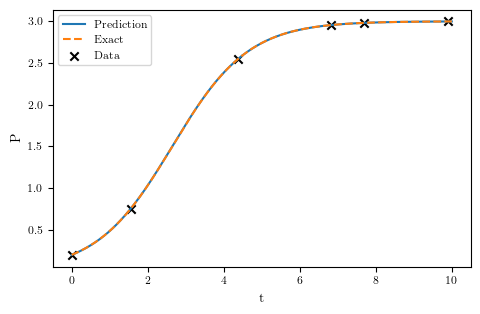

In [12]:
plt.plot(T, u_pred, label='Prediction')
plt.plot(T, P, linestyle='--', label='Exact')
plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t')
plt.ylabel('P')
plt.savefig('Simple_Result.pdf')
plt.show()

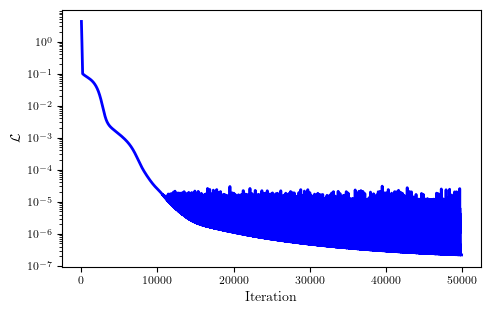

In [13]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.savefig('Simple_Loss.pdf')
plt.show()